# Computing Zonal Statistics with ASTER Thermal Infrared GeoTIFFs

AST_L1T: [ASTER Level 1 Precision Terrain Corrected Registered At-Sensor Radiance](https://lpdaac.usgs.gov/products/ast_l1tv003/)

### AST_L1T GeoTIFFs

The TIR AST_L1T GeoTIFFs: 
* B14 (Red), B12 (Green), B10 (Blue)
* 90 m/px
* Degrees Kelvin scaled from 16-bit to 8-bit ????

### Radiometry:

AST_L1T TIR data are scaled to digital number values for the TIR bands as follows:
* DN of 0 corresponds to "no data"
* DN of 1 corresponds to a radiance of 0 $W m^{-2} sr^{-1} \mu m^{-1}$
* DN of 4094 is the maximum radiance for TIR bands
* DN of 4095 is the value for saturated pixels in TIR bands

At-Sensor Radiance (L) is calculated from DNs using the Unit Conversion Coefficients $[W m^{-2} sr^{-1} \mu m^{-1} / DN]$ :

<div style="font-size: 130%;", align="center">
$L_s = (DN - 1) \times ucc$
</div>

Brightness temperature is calculated from radiances (L) using the constants K1 $[W m^{-2} sr^{-1} \mu m^{-1}]$ and K2 $[K]$ in the Planck formula:

<div style="font-size: 170%;", align="center">
$T_b = \frac{K_2}{ln (\frac{K_1}{L_s} + 1)}$
</div>

| Band | Wavelength ($\mu m$)| ucc          | K1      | K2      |
| ---  | ---                 | ---          | ---     | ---     |
| 10   | 8.125–8.475         | 6.822 x 10-3 | 3047.47 | 1736.18 |
| 11   | 8.475–8.825         | 6.780 x 10-3 | 2480.93 | 1666.21 |
| 12   | 8.925–9.275         | 6.590 x 10-3 | 1930.80 | 1584.72 |
| 13   | 10.250–10.950       | 5.693 x 10-3 | 865.65  | 1349.82 |
| 14   | 10.950–11.650       | 5.225 x 10-3 | 649.60  | 1274.49 |



---
See also: *Jiménez-Muñoz, J. C., & Sobrino, J. A. (2009). A single-channel algorithm for land-surface temperature retrieval from ASTER data. IEEE Geoscience and Remote Sensing Letters, 7(1), 176-179.*

*Portions of this notebook were derived from [this example with Sentinel satellite imagery](https://github.com/shakasom/zonalstatistics/).*

---
To do:
- fix nodata issue in masking (you can see all the zeros I end up with in this histograms, which I want to convert to nan values so that I can ignore them)

---

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box, mapping
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.mask import mask
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#https://pypi.org/project/matplotlib-scalebar/
#ax.add_artist(Scalebar(res)) where res is the pixel resolution in meters
#If already set imshow(extent=extent) parameter, use res=1.0
import warnings
warnings.filterwarnings('ignore')

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

---

### Open an ASTER TIR image

In [4]:
# inspect metadata with gdal
#!gdalinfo "\\j-lundquist-3.ce.washington.edu\storage\spestana\ASTER\AST_L1T\geotiff\T\T_band14_Tuolumne-and-CUES\AST_L1T_00311262018060119_20181128034140_15697_ImageData14.tif"

Reproject ASTER image to WGS84

In [5]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'


with rasterio.open(r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif") as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14_wgs84.tif", 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [6]:
#src = rio.open(r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14_wgs84.tif")
# src.meta
# src.count, src.width, src.height

Open Shapefiles

In [7]:
# point shapefiles
#mesa_west = gpd.read_file('zip://../data/shapefiles/MW.zip')
#snow_pit = gpd.read_file('zip://../data/shapefiles/2s10.zip')

mesa_west = gpd.read_file(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GrandMesaGIS\mesa west site.shp')
snow_pit = gpd.read_file(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx2020_GIS\2s10.shp')

# add buffers
r = 0.001 # units?
mesa_west_buffer = mesa_west.buffer(r)
snow_pit_buffer = snow_pit.buffer(r)

### Unit conversions
Convert DN to radiance, then radiance to brightness temperature

In [8]:
file = r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14_wgs84.tif"

    
aster_b14_DN = xr.open_rasterio(file)
aster_b14_DN = aster_b14_DN[0]



In [9]:
aster_b14_DN

<xarray.DataArray (y: 729, x: 1053)>
[767637 values with dtype=uint16]
Coordinates:
    band     int32 1
  * y        (y) float64 39.34 39.33 39.33 39.33 ... 38.65 38.65 38.65 38.65
  * x        (x) float64 -108.7 -108.7 -108.7 -108.7 ... -107.7 -107.7 -107.7
Attributes:
    transform:      (0.0009387891832370387, 0.0, -108.70436500106831, 0.0, -0...
    crs:            +init=epsg:4326
    res:            (0.0009387891832370387, 0.0009387891832370387)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [10]:
# change data type to float64 so we can fill in DN=0 with NaN values
#aster_b14_DN = aster_b14_DN.astype('float64')
#aster_b14_DN == 0
#aster_b14_DN[aster_b14_DN==0] = np.nan

#aster_b14_DN = aster_b14_DN.sel(( (rainier['time.month'] == 4) & (rainier['time.day'] == 1) ) )

In [11]:


# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
aster_b14_rad = tir_dn2rad(aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature
aster_b14_tb = tir_rad2tb(aster_b14_rad, band_number)


# Convert from K to C
aster_b14_tb = aster_b14_tb - 273.15

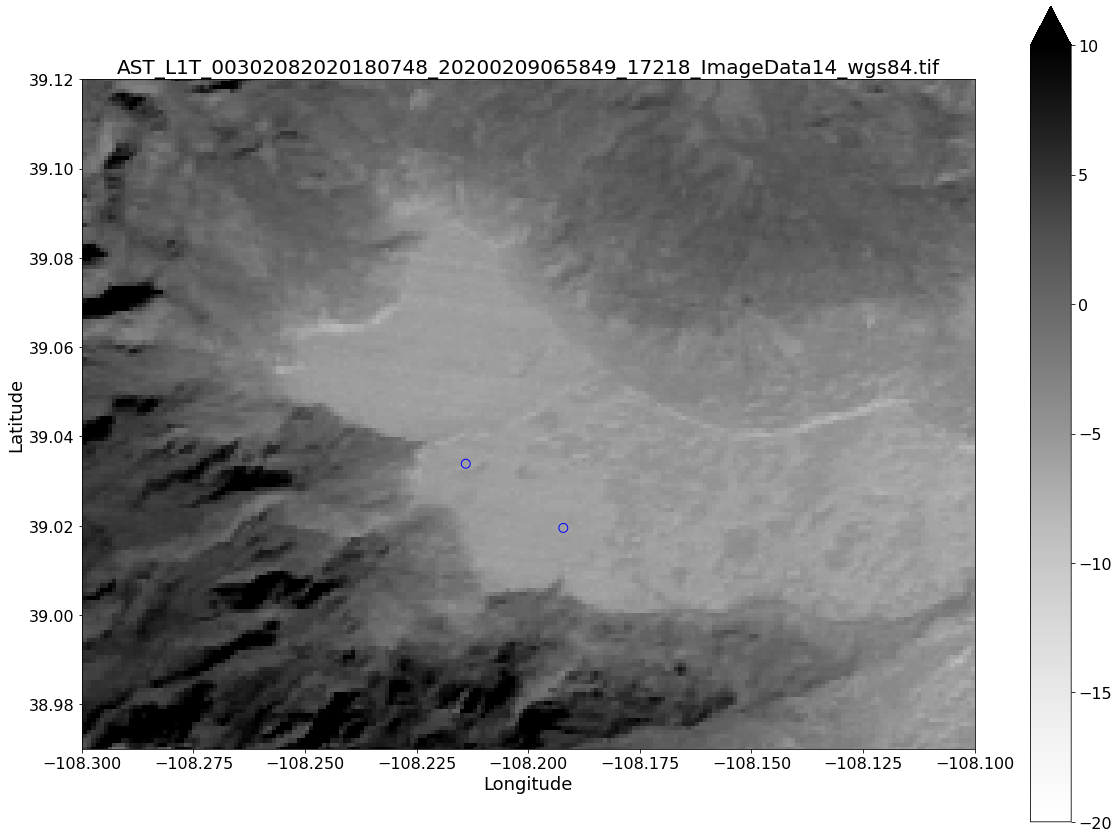

In [12]:
# make sure we're in the same CRS

mesa_west_buffer = mesa_west_buffer.to_crs(aster_b14_DN.crs)
snow_pit_buffer = snow_pit_buffer.to_crs(aster_b14_DN.crs)

#print('ECOSTRESS CRS: {}'.format(eco_lst.crs))
#print('Shapefile CRS: {}'.format(mesa_west_buffer.crs))
#print('Shapefile CRS: {}'.format(snow_pit_buffer.crs))



#Plot our ASTER image and two buffered points

fig, ax = plt.subplots(figsize=(20,15))

aster_b14_tb.plot(x='x', y='y', ax=ax, vmin=-20, vmax=10, cmap='Greys')

mesa_west_buffer.plot(ax=ax, edgecolor='blue', facecolor='none');
snow_pit_buffer.plot(ax=ax, edgecolor='blue', facecolor='none');

ax.set_xlim((-108.3, -108.1))
ax.set_ylim((38.97, 39.12))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(file.split('\\')[-1])

ax.set_aspect(1)
#plt.savefig('{}.jpg'.format(file.split('\\')[-1]),dpi=300)


### Mask the ASTER TIR image to the area of the shapefile

Mean: -6.1
Max: -6.0
Min: -6.1
Std: 0.0
Mean: -5.8
Max: -5.6
Min: -6.0
Std: 0.2


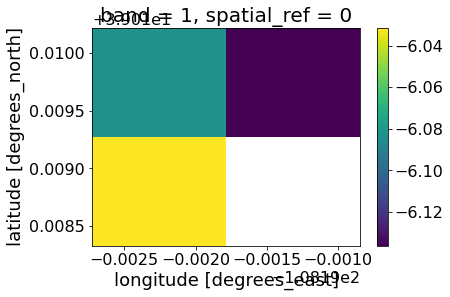

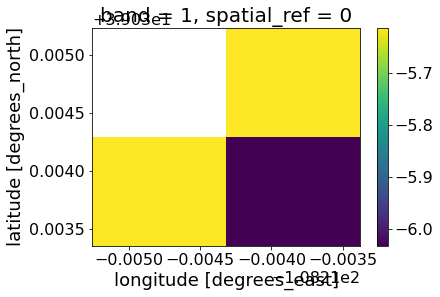

In [13]:
for shapefile in [snow_pit_buffer, mesa_west_buffer]:

    shapefile_DN = aster_b14_DN.rio.clip(shapefile.geometry.apply(mapping), crs=aster_b14_DN.crs)

    # switch our zero values to nan values
    shapefile_DN = shapefile_DN.where(shapefile_DN > 0)

    
    # ASTER band number for conversion functions
    band_number = 14
    
    # Convert DN to Radiance
    shapefile_rad = tir_dn2rad(shapefile_DN, band_number)
    
    # Convert Radiance to Brightness Temperature
    shapefile_tb = tir_rad2tb(shapefile_rad, band_number)
    
    
    # Convert from K to C
    shapefile_tb = shapefile_tb - 273.15
    

    # Compute zonal statistics
    # Remove NaN pixel values
    values = shapefile_tb.values.flatten()
    values = values[~np.isnan(values)]

    tb_mean = values.mean()
    tb_max = values.max()
    tb_min = values.min()
    tb_std = values.std()

    # Print zonal statistics
    summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(tb_mean,1),
                                                                 np.round(tb_max,1),
                                                                 np.round(tb_min,1),
                                                                 np.round(tb_std,1))

    print(summary_stats)
    plt.figure()
    shapefile_tb.plot()

---
---

In [14]:
# change data type to float64 so we can fill in DN=0 with NaN values
masked_aster_b14_DN = masked_aster_b14_DN.astype('float64')
masked_aster_b14_DN[masked_aster_b14_DN==0] = np.nan

# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
masked_aster_b14_rad = tir_dn2rad(masked_aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature
masked_aster_b14_tb = tir_rad2tb(masked_aster_b14_rad, band_number)

# Remove the extra dimension (bands, we only have one band here)
masked_aster_b14_tb = masked_aster_b14_tb.squeeze()

# Convert from K to C
masked_aster_b14_tb = masked_aster_b14_tb - 273.15

NameError: name 'masked_aster_b14_DN' is not defined

In [ ]:
# Compute zonal statistics
# Remove NaN pixel values
values = masked_aster_b14_tb.flatten()
values = values[~np.isnan(values)]

masked_aster_b14_tb_mean = values.mean()
masked_aster_b14_tb_max = values.max()
masked_aster_b14_tb_min = values.min()
masked_aster_b14_tb_std = values.std()

# Print zonal statistics
print('Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(masked_aster_b14_tb_mean,
                                                   masked_aster_b14_tb_max,
                                                   masked_aster_b14_tb_min,
                                                   masked_aster_b14_tb_std))

### Open a shapefile
(these will be the GOES pixel footprints)

In [15]:
testshape = gpd.read_file(r"C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/SnowEx/grand_mesa_bounding_box.shp")
testshape.head()

,MINX,MINY,MAXX,MAXY,CNTX,CNTY,AREA,PERIM,HEIGHT,WIDTH,geometry
0,711855.0,4281255.0,795285.0,4354785.0,753570.0,4318020.0,6.134608e+09,313920.0,73530.0,83430.0,"POLYGON ((711855.000 4281255.000, 711855.000 4..."


In [ ]:
testshape = gpd.read_file(r"C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/SnowEx/grand_mesa_bounding_box.shp")
testshape.head()

Make sure our shapefile is the same CRS as the ASTER TIR image

In [16]:
print('ASTER CRS: {}'.format(src.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: EPSG:32612
Shapefile CRS: epsg:32612


In [17]:
testshape = testshape.to_crs(src.crs)

In [18]:
print('ASTER CRS: {}'.format(src.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: EPSG:32612
Shapefile CRS: PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32612"]]


### Mask the ASTER TIR image to the area of the shapefile

In [21]:
with rasterio.open(r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif") as src:

    masked_aster_b14_DN, mask_transform = mask(dataset=src, 
                                               shapes=testshape.geometry,
                                               crop=True,
                                               all_touched=True,
                                               filled=True)

    # We still have a "bands" axis even though there's only one band, we can remove it below
    masked_aster_b14_DN.shape

In [22]:
# change data type to float64 so we can fill in DN=0 with NaN values
masked_aster_b14_DN = masked_aster_b14_DN.astype('float64')
masked_aster_b14_DN[masked_aster_b14_DN==0] = np.nan

# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
masked_aster_b14_rad = tir_dn2rad(masked_aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature
masked_aster_b14_tb = tir_rad2tb(masked_aster_b14_rad, band_number)

# Remove the extra dimension (bands, we only have one band here)
masked_aster_b14_tb = masked_aster_b14_tb.squeeze()

# Convert from K to C
masked_aster_b14_tb = masked_aster_b14_tb - 273.15

### Calculate zonal statistics for this area
(mean, max, min, std:)

In [23]:
# Compute zonal statistics
# Remove NaN pixel values
values = masked_aster_b14_tb.flatten()
values = values[~np.isnan(values)]

masked_aster_b14_tb_mean = values.mean()
masked_aster_b14_tb_max = values.max()
masked_aster_b14_tb_min = values.min()
masked_aster_b14_tb_std = values.std()

# Print zonal statistics
print('Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(masked_aster_b14_tb_mean,
                                                   masked_aster_b14_tb_max,
                                                   masked_aster_b14_tb_min,
                                                   masked_aster_b14_tb_std))

Mean: 4.155969809692161
Max: 27.4213627977457
Min: -13.943919126258265
Std: 5.598954120075219


Plot

In [24]:
src.crs

CRS.from_epsg(32612)

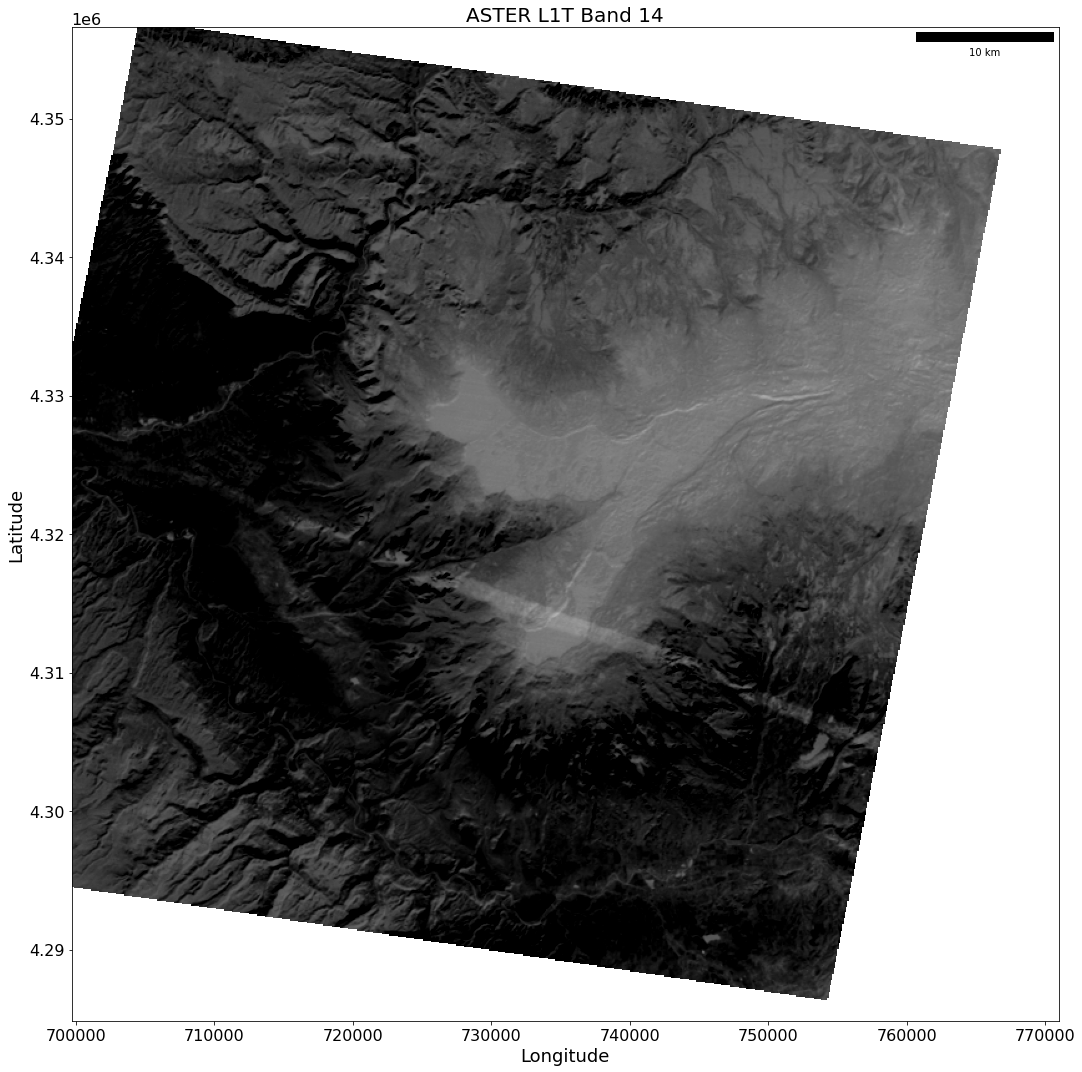

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(20, 15), 
                       tight_layout=True)

# plot ASTER image
rioplt.show(masked_aster_b14_tb, transform=src.transform, ax=ax, vmin=-30, vmax=10, cmap='Greys')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('ASTER L1T Band 14')
# Add scalebar
scalebar = ScaleBar(1, length_fraction=0.15) # get image resolution from original raster image (1 pixel = X meters)
ax.add_artist(scalebar) 
#ax.set_xlim((-108.3, -108.1))
#ax.set_ylim((38.97, 39.12))

---
### Plots

**TO DO** 
* add subplot zoomed in on area outlined by shapefile
* add scalebars to plot and subplot
* add colorbar for brightness temperature values
* format title, axes, labels, legend
* add histogram plots for main plot and subplot area

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize=(15, 5), 
                       gridspec_kw={'width_ratios': [2, 1]}, 
                       tight_layout=True)

# plot ASTER image
rioplt.show(aster_b14_tb, transform=src.transform, ax=ax[0], cmap='Greys_r')
ax[0].set_ylabel('UTM N, Z11N [m]')
ax[0].set_xlabel('UTM E, Z11N [m]')
ax[0].set_title('ASTER L1T Band 14')
# Add scalebar
scalebar = ScaleBar(1, length_fraction=0.15) # get image resolution from original raster image (1 pixel = X meters)
ax[0].add_artist(scalebar) 

# Plot shapefile outline
testshape.plot(ax=ax[0], color="none", ec='red', linewidth=2, linestyle='-', alpha=1)
# Center this plot on the shapefile
center_x = testshape.geometry.centroid.x.values[0]
center_y = testshape.geometry.centroid.y.values[0]
ax[0].set_xlim([center_x-40000, center_x+40000])
ax[0].set_ylim([center_y-40000, center_y+40000])
                              


# Plot ASTER image cropped to shapefile
aster_inset_ax = inset_axes(ax[0],
                    width=1.5, # width : 1 inch
                    height=1.5, # height : 1 inch
                    loc=2)
image_data = masked_aster_b14_tb
rio.plot.show(image_data,
              ax=aster_inset_ax,
              cmap='Greys_r')
#scalebar = ScaleBar(src.res[0]) # get image resolution from original raster image
#aster_inset_ax.add_artist(scalebar)
aster_inset_ax.tick_params(axis='both', bottom=False, top=False, left=False, right=False)
aster_inset_ax.xaxis.set_ticklabels([])
aster_inset_ax.yaxis.set_ticklabels([])


# Plot a histogram
tb_c = aster_b14_tb.flatten() - 273.15 # convert from brightness temp in K to C, and flatten to a 1-D array
ax[1].hist(tb_c, bins=100, facecolor='k');
ax[1].set_ylabel('Pixel Count')
ax[1].set_xlabel('Brightness Temperature [$\degree C$]')
ax[1].set_title('ASTER L1T Band 14 Histogram')

# Plot histogram for area within shapefile
hist_inset_ax = inset_axes(ax[1],
                    width=1.5, # width : 1 inch
                    height=1.5, # height : 1 inch
                    loc=1)
hist_inset_ax.hist(values-273.15, bins=50, facecolor='k');
hist_inset_ax.axvline(x=masked_aster_b14_tb_mean-273.15, c='r', linestyle='--')

# Plot summary statistics
summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(masked_aster_b14_tb_mean-273.15,1),
                                                             np.round(masked_aster_b14_tb_max-273.15,1),
                                                             np.round(masked_aster_b14_tb_min-273.15,1),
                                                             np.round(masked_aster_b14_tb_std,1))
hist_inset_ax.text(-15,100,summary_stats)

plt.show();

